# Dipole autoencoding
Testing autoencoding of simulated current dipoles

In [1]:
import torch
from torch import nn
import dill
import os.path as op
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import multiprocessing
import pandas as pd
import sys
sys.path.append('../')
import spike_train_functions
import hnn_simnets_functions
import numba
import sbi_functions
import umap
import umap.plot
import multiprocessing
num_cores = multiprocessing.cpu_count()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0")
# device = torch.device("cpu")
import torch.nn.functional as F


/home/ntolley/anaconda3/lib/python3.7/site-packages/elephant/pandas_bridge.py:22: DeprecationWarning: pandas_bridge module will be removed in Elephant v0.8.x
  DeprecationWarning)
/home/ntolley/anaconda3/lib/python3.7/site-packages/holoviews/operation/datashader.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Callable


In [2]:
save_name = 'beta_event_expanse_t100000_02142021_182526'
data_path = '/home/ntolley/Jones_Lab/sbi_hnn/data/beta/prerun_simulations/' + save_name + '/'
dpl_all = np.loadtxt(data_path + 'dpl_100x_downsample.csv', delimiter=',')
theta_all = np.loadtxt(data_path + 'theta_all.csv', delimiter=',')
sim_length = 500 # in ms
sim_times_all = np.linspace(0,sim_length, dpl_all.shape[1])


In [3]:
# Parameters
batch_size = 1000
train_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':True}


# Generators
training_set = sbi_functions.HNNDataset(dpl_all, theta_all, device)
training_generator = torch.utils.data.DataLoader(training_set, **train_params)


In [18]:
# Define hyperparameters
lr=1e-3
weight_decay=1e-20
# dropout=0.8


# window_size=10
input_size = training_set[0][0].shape[0]
# hidden_size = 10
# step_size = 1
latent_dim = 10
layer_size = [500,100,latent_dim]
max_epochs=10000

#Define model
# model =  sbi_functions.autoencoder_gru(input_size=input_size, hidden_size=hidden_size, layer_size=layer_size, window_size=window_size, step_size=step_size, dropout=dropout, device=device).to(device)

model = sbi_functions.autoencoder_linear(input_size=input_size, layer_size=layer_size, device=device)

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



In [19]:
train_loss_array = []
model.train()
# Loop over epochs
for epoch in range(max_epochs):
    train_batch_loss = [] 
    for batch, _ in training_generator:
        optimizer.zero_grad() # Clears existing gradients from previous epoch
        batch = batch.float().to(device)
        output, latent = model(batch)
        train_loss = criterion(output, batch)
        train_loss.backward() # Does backpropagation and calculates gradients
        optimizer.step() # Updates the weights accordingly

        train_batch_loss.append(train_loss.item())
        print('*',end='')
    train_loss_array.append(train_batch_loss)
    #Print Loss
    if (epoch+1)%1 == 0:
        print('')
        print('Epoch: {}/{} ...'.format(epoch+1, max_epochs), end=' ')
        print('Train Loss: ' + str(np.mean(train_batch_loss)))



/10000 ... Train Loss: 73538.391953125
****************************************************************************************************
Epoch: 109/10000 ... Train Loss: 73029.069921875
****************************************************************************************************
Epoch: 110/10000 ... Train Loss: 72479.407109375
****************************************************************************************************
Epoch: 111/10000 ... Train Loss: 71996.6525
****************************************************************************************************
Epoch: 112/10000 ... Train Loss: 71513.857734375
****************************************************************************************************
Epoch: 113/10000 ... Train Loss: 70962.9296875
****************************************************************************************************
Epoch: 114/10000 ... Train Loss: 70478.5006640625
*******************************************************************

KeyboardInterrupt: 

In [20]:
latent_test = latent.detach().cpu().numpy().squeeze()
output_test = output.detach().cpu().numpy().squeeze()
input_test = batch.detach().cpu().numpy().squeeze()

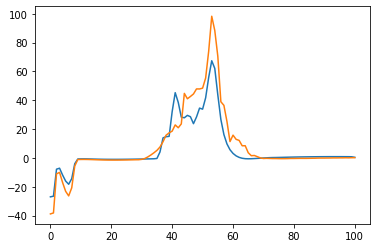

In [26]:
idx = 190
plt.plot(input_test[idx,:])
plt.plot(output_test[idx,:])


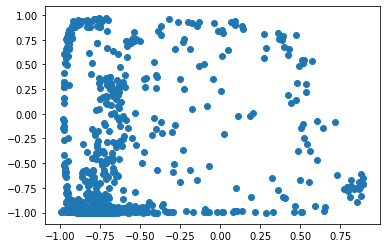

In [28]:
for idx in range(20)
    scaled_dpl = input_test[idx,:]/np.max(np.abs(input_test[idx,:]))
    x_pts = np.linspace(0, 0.1, len(scaled_dpl))

    plt.scatter(latent_test[:,0], latent_test[:,1])